# Предсказание зарплат
## Анализ данных

In [513]:
# обновление пакетов
!python -m pip install --upgrade pip
!pip install --upgrade click

# установка spaCy
!pip install spacy

# установка русскоязычного корпуса
!python -m spacy download ru_core_news_sm

# установка gensim
!pip install gensim

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


     --------------------------------------- 15.3/15.3 MB 21.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
# подключение библиотек
import numpy as np
import pandas as pd
import gensim.models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import spacy
import re
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Функция удаления выбросов
def drop_outliers(df):
    low = .25
    high = .75

    filt_df = df

    quant_low  = filt_df.quantile(low, axis=0)
    quant_high = filt_df.quantile(high, axis=0)

    interquartile_range = (quant_high - quant_low) * 1.5

    min_val = quant_low - interquartile_range
    max_val = quant_high + interquartile_range

    filt_df = filt_df.loc[(filt_df['salary_from'] >= min_val['salary_from']) & (filt_df['salary_from'] <= max_val['salary_from'])]
    filt_df = filt_df.loc[(filt_df['salary_to'] >= min_val['salary_to']) & (filt_df['salary_to'] <= max_val['salary_to'])]
    
    return filt_df


# Функция, возвращает векторизированное предложение
def get_vector(model, sentence):
    sentence_vector = []

    if len(sentence) == 0:
        # Пустые предложения заполним их одним  словом
        token_vector = np.zeros(256)
        sentence_vector.append(token_vector)
    else:
        for token in sentence:
            try:
                token_vector = model.wv[token]
            except KeyError as e:
                # Случай  слова
                token_vector = np.zeros(256)
            finally:
                sentence_vector.append(token_vector)

    return np.mean(sentence_vector, axis=0)

### Загрузка данных

In [3]:
df = pd.read_csv('data_vacancies.csv')
df.tail(5)

,id,custom_position,schedule,salary_from,salary_to,salary_pay_type,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
19484,48737855,Кладовщик,полный рабочий день,45000,70000,NaN,2,среднее профессиональное,True,20,1,[3],"['комплектация заказов', 'работа с документаци...",NaN
19485,48737859,Кассир,сменный график,35000,58000,NaN,0,любое,True,0,1,[3],"['ответственность', 'контроль срока годности',...","[5, 6]"
19486,48737860,Инженер по медицинской технике,полный рабочий день,77000,77000,NaN,4,высшее,True,10,1,[3],"['уверенный пользователь ПК', 'ремонт оборудов...",NaN
19487,48737871,Автомеханик-автослесарь,полный рабочий день,80000,120000,NaN,0,любое,True,0,2,[4],"['устройство автомобилей', 'ремонт тормозной с...",NaN
19488,48737872,Автомеханик-автослесарь,полный рабочий день,80000,120000,NaN,0,любое,True,0,102,"[1166, 1189, 1777, 1781, 1783, 11677]","['устройство автомобилей', 'ремонт тормозной с...",NaN


In [4]:
# размер выборки и кол-во признаков
df.shape

(19489, 14)

In [5]:
# проверка на пустые значения
df.isna().sum()

id                         0
custom_position            0
schedule                   0
salary_from                0
salary_to                  0
salary_pay_type        19383
offer_education_id         0
education_name             0
education_is_base          0
education_order_num        0
city_id                    0
list_regions               0
work_skills                0
tags_id                 5999
dtype: int64

Признак salary_pay_type большую часть выборки Nan. Неинформативный. \
Уникальный индентификатор неинформативен.\
\
tags_id представляет список тегов. Подумать, как с ним работать.

In [6]:
df.drop(['salary_pay_type'], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)

In [7]:
# информация о типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19489 entries, 0 to 19488
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   custom_position      19489 non-null  object
 1   schedule             19489 non-null  object
 2   salary_from          19489 non-null  int64 
 3   salary_to            19489 non-null  int64 
 4   offer_education_id   19489 non-null  int64 
 5   education_name       19489 non-null  object
 6   education_is_base    19489 non-null  bool  
 7   education_order_num  19489 non-null  int64 
 8   city_id              19489 non-null  int64 
 9   list_regions         19489 non-null  object
 10  work_skills          19489 non-null  object
 11  tags_id              13490 non-null  object
dtypes: bool(1), int64(5), object(6)
memory usage: 1.7+ MB


Категориальные признаки:
* custom_position
* schedule       
* education_name 
* list_regions     
* work_skills      
* tags_id

Логический признак:
* education_is_base

Числовые признаки:     
* salary_from
* salary_to  
* offer_education_id
* education_order_num 
* city_id             

Проведём обработку данных

### Категориальные признаки

##### 1. Обработка логического признака education_is_base

In [8]:
df['education_is_base'].value_counts()

True    19489
Name: education_is_base, dtype: int64

In [9]:
le_logic = LabelEncoder()
le_logic.fit([False, True])

df['education_is_base'] = le_logic.transform(df['education_is_base'])

##### 2. Обработка education_name

In [10]:
df['education_name'].value_counts()

любое                       16740
среднее профессиональное     1168
высшее                        924
среднее                       577
неполное высшее                80
Name: education_name, dtype: int64

Text(0.5, 1.0, 'Гистограмма education_name')

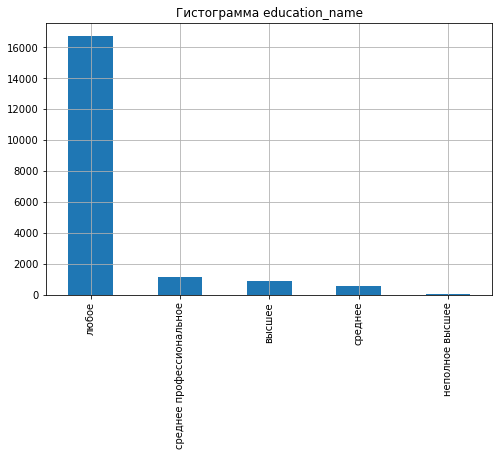

In [11]:
plt.figure(figsize=(8, 5))
df['education_name'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма education_name")

In [12]:
le_edname = LabelEncoder()
le_edname.fit(df['education_name'])

df['education_name'] = le_edname.transform(df['education_name'])

##### 3. Обработка schedule

In [13]:
df['schedule'].value_counts()

полный рабочий день    7462
сменный график         6126
удаленная работа       2986
свободный график       1327
вахта                  1302
частичная занятость     286
Name: schedule, dtype: int64

Text(0.5, 1.0, 'Гистограмма schedule')

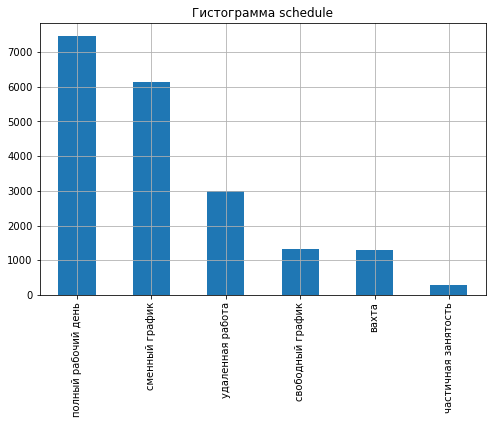

In [14]:
plt.figure(figsize=(8, 5))
df['schedule'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма schedule")

In [15]:
le_schedule = LabelEncoder()
le_schedule.fit(df['schedule'])

df['schedule'] = le_schedule.transform(df['schedule'])

##### 4. Обработка tags_id

In [16]:
df['tags_id'] = np.where(df['tags_id'].isna(), '[0]', df['tags_id'])
df['tags_id'] = df['tags_id'].apply(lambda x: x[1:-1].split(', '))

##### 5. Обработка list_regions

In [17]:
df['list_regions'] = df['list_regions'].apply(lambda x: x[1:-1].split(', '))

##### 6. Обработка custom_position
###### Удаление выбросов

In [18]:
df.head(5)

,custom_position,schedule,salary_from,salary_to,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
0,Сварщик-сборщик,1,60000,120000,0,1,1,0,2,[4],"['сварочные работы', 'сборка изделий по чертеж...",[0]
1,Сварщик-монтажник,1,60000,120000,0,1,1,0,2,[4],"['монтажные работы', 'строительные работы', 'э...",[0]
2,Слесарь-сборщик,1,60000,80000,0,1,1,0,2,[4],"['работа на фрезерных станках', 'слесарный рем...",[0]
3,Грузчик-упаковщик,5,30000,35000,0,1,1,0,1,[3],"['комплектация товара', 'маркировка', 'стрессо...","[6, 9]"
4,Грузчик-упаковщик,5,30000,35000,0,1,1,0,57,"[181, 182, 183, 185, 186, 187, 188, 189, 190, ...","['маркировка', 'стрессоустойчивость', 'погрузо...","[6, 9]"


Вообще говоря, в вакансии могут быть не указаны salary_from и salary_to

Text(0.5, 1.0, 'Ящик с усами для salary')

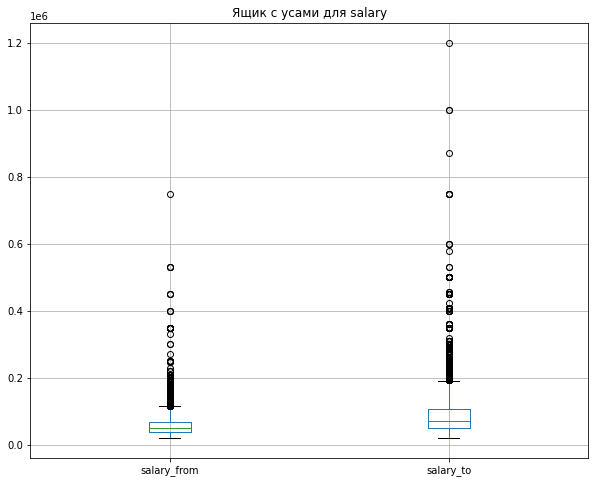

In [19]:
plt.figure(figsize=(10, 8))
boxplot = df.boxplot(column=['salary_from', 'salary_to'])  
plt.title("Ящик с усами для salary")

Видно, что анализируя поле salary_from и salary_to мы обобщаяем все профессии, из-за чего имеем много выбросов. При попытке их обработать значительно уменьшится выборка. \
\
**Решение**: обработать поле custom_position на уникальные поля, после чего обработать выбросы.

In [20]:
df['custom_position'].describe()

count               19489
unique               7023
top       Продавец-кассир
freq                  409
Name: custom_position, dtype: object

In [21]:
df['custom_position'].value_counts()

Продавец-кассир                                                                        409
Менеджер по продажам                                                                   290
Продавец-консультант                                                                   238
Курьер                                                                                 193
Охранник                                                                               134
                                                                                      ... 
Рабочий на производство (доводчик изделий)                                               1
Работник торгового зала (Одинцово)                                                       1
Электромонтер по ремонту и обслуживанию почтообрабатывающего оборудования 6 разряда      1
Оператор-маркетолог                                                                      1
Менеджер проектов / делопроизводитель                                                    1

In [22]:
df['custom_position'] = df['custom_position'].apply(lambda x: ' '.join((re.sub(r'\([^)]*?\)', '', x)).split()))

In [23]:
df['custom_position'].describe()

count               19489
unique               5029
top       Продавец-кассир
freq                  890
Name: custom_position, dtype: object

In [24]:
df['custom_position'].value_counts()

Продавец-кассир                                          890
Менеджер по продажам                                     413
Продавец-консультант                                     290
Оператор call-центра                                     227
Курьер                                                   213
                                                        ... 
геодезист камеральщик                                      1
Специалист документооборота/Сканировщик писем и почты      1
Начальник химической лаборатории                           1
Комплектовщик заказов на Яндекс.Маркет                     1
Декоратор купальников                                      1
Name: custom_position, Length: 5029, dtype: int64

Почистим данные от выбросов по salary_from и salary_to:

In [25]:
top200_profs = df['custom_position'].value_counts().nlargest(200)
top200_profs

Продавец-кассир                   890
Менеджер по продажам              413
Продавец-консультант              290
Оператор call-центра              227
Курьер                            213
                                 ... 
Начинающий специалист              15
Мерчендайзер-грузчик ФиксПрайс     15
Специалист отдела продаж           15
Тракторист                         15
Сиделка                            15
Name: custom_position, Length: 200, dtype: int64

In [26]:
# удаление выбросов для топ200 профессий
df_clear = pd.DataFrame(columns=df.columns)

for prof in top200_profs.index:
    df_temp = df[df['custom_position'] == prof]
    df_temp = drop_outliers(df_temp)
    df_clear = pd.concat([df_clear, df_temp])
    
# добавление остальных строк
df_temp = df

for prof in top200_profs.index:
    df_temp = df_temp.drop(df_temp[df_temp['custom_position'] == prof].index)

df_clear = pd.concat([df_clear, df_temp])

In [27]:
df_clear.reset_index(drop=True, inplace=True)

###### Токенизация

In [28]:
df_clear['custom_position'].describe()

count               18543
unique               5029
top       Продавец-кассир
freq                  825
Name: custom_position, dtype: object

In [29]:
nlp = spacy.load("ru_core_news_sm")

df_clear['custom_position'] = df_clear['custom_position'].apply(
    lambda x: [str(token).lower() for token in nlp(x) if
      not token.is_stop
      and not token.is_punct
      and not token.is_digit
      and not token.like_email
      and not token.like_num
      and not token.is_space
    ]
  )   

In [30]:
df_clear.tail(5)

,custom_position,schedule,salary_from,salary_to,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
18538,"[кассир, кафе, азс]",3,44000,60000,0,1,1,0,57,"[192, 1213, 5089]","['ответственность', 'продажи', 'работа на касс...","[5, 6, 9]"
18539,"[комплектовщик, склад, интернет, заказов]",1,110000,145000,0,1,1,0,57,"[181, 182, 183, 185, 186, 187, 188, 189, 190, ...","['фасовка товара', 'выкладка товара', 'стрессо...",[0]
18540,"[водитель, такси, парковый, авто]",5,85000,120000,0,1,1,0,1,[3],"['спокойный стиль вождения', 'ответственность'...","[5, 6, 9]"
18541,"[начальник, участка]",1,100000,100000,4,0,1,10,1,[3],['Организация общестроительных работ'],[0]
18542,"[инженер, медицинской, технике]",1,77000,77000,4,0,1,10,1,[3],"['уверенный пользователь ПК', 'ремонт оборудов...",[0]


##### 7. Обработка work_skills

In [31]:
df_clear['work_skills'] = df_clear['work_skills'].apply(
    lambda x: ''.join(x[1:-1].split(",")).replace("'", "")
)

In [32]:
df_clear['work_skills'] = df_clear['work_skills'].apply(
    lambda x: [str(token).lower() for token in nlp(x) if
      not token.is_stop
      and not token.is_punct
      and not token.is_digit
      and not token.like_email
      and not token.like_num
      and not token.is_space
    ]
  )

In [33]:
df_clear.head(5)

,custom_position,schedule,salary_from,salary_to,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,work_skills,tags_id
0,"[продавец, кассир]",1,52000,58000,0,1,1,0,2,[4],"[выкладка, товара, работа, кассе, обслуживание...","[6, 9]"
1,"[продавец, кассир]",3,38000,38000,0,1,1,0,2,[4],"[выкладка, товара, умение, продавать, консульт...",[0]
2,"[продавец, кассир]",3,35000,40000,0,1,1,0,57,[207],"[выкладка, товара, работа, кассе, участие, про...",[9]
3,"[продавец, кассир]",3,37000,42000,0,1,1,0,57,[1269],"[работа, кассе, работа, торговом, зале, участи...",[9]
4,"[продавец, кассир]",1,33600,63000,0,1,1,0,57,[1220],"[работа, кассе, ответственность, доброжелатель...",[0]


### Числовые признаки

In [34]:
df_clear['salary_from'] = df_clear['salary_from'].apply(lambda x: int(x))
df_clear['salary_to'] = df_clear['salary_to'].apply(lambda x: int(x))

##### 1. salary_from и salary_to

In [35]:
print(df_clear['salary_from'].describe())
print(df_clear['salary_from'].mode())

count    18543.000
mean     58471.345
std      29522.265
min      20500.000
25%      40000.000
50%      50000.000
75%      70000.000
max     750000.000
Name: salary_from, dtype: float64
0    60000
dtype: int64


Text(0.5, 1.0, 'Гистограмма для salary_from')

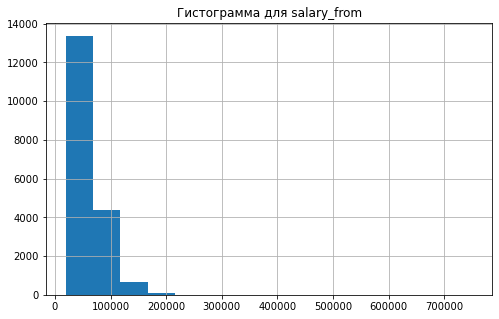

In [36]:
plt.figure(figsize=(8, 5))
df_clear['salary_from'].hist(bins=1 + int(np.log2(df_clear['salary_from'].shape[0])))
plt.title("Гистограмма для salary_from")

In [37]:
print(df_clear['salary_to'].describe())
print(df_clear['salary_to'].mode())

count     18543.000
mean      87402.705
std       53770.738
min       21000.000
25%       51000.000
50%       71000.000
75%      104000.000
max     1200000.000
Name: salary_to, dtype: float64
0    50000
dtype: int64


Text(0.5, 1.0, 'Гистограмма для salary_to')

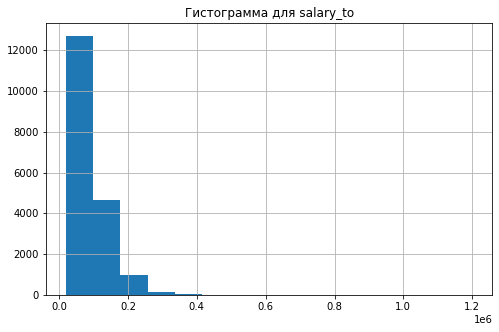

In [38]:
plt.figure(figsize=(8, 5))
df_clear['salary_to'].hist(bins=1 + int(np.log2(df_clear['salary_to'].shape[0])))
plt.title("Гистограмма для salary_to")

##### 2. offer_education_id

In [39]:
df_clear['offer_education_id'].value_counts()

0    15877
2     1138
4      908
1      544
3       76
Name: offer_education_id, dtype: int64

Text(0.5, 1.0, 'Гистограмма для offer_education_id')

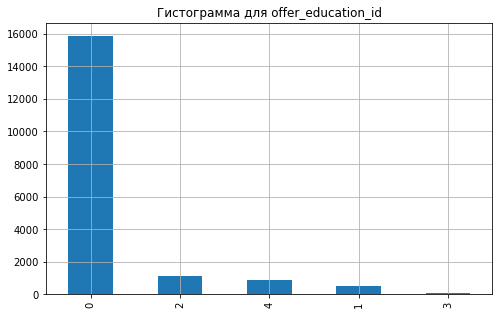

In [40]:
plt.figure(figsize=(8, 5))
df_clear['offer_education_id'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма для offer_education_id")

##### 3. education_order_num

In [41]:
df_clear['education_order_num'].value_counts()

0     15877
20     1138
10      908
25      544
15       76
Name: education_order_num, dtype: int64

Text(0.5, 1.0, 'Гистограмма для education_order_num')

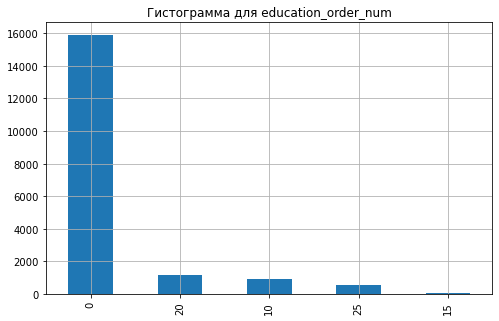

In [42]:
plt.figure(figsize=(8, 5))
df_clear['education_order_num'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма для education_order_num")

##### 4. city_id

In [43]:
df_clear['city_id'].value_counts()

1      9119
57     4061
2      3267
102     779
174     284
       ... 
54        4
256       3
268       3
272       2
252       1
Name: city_id, Length: 65, dtype: int64

Text(0.5, 1.0, 'Гистограмма для city_id')

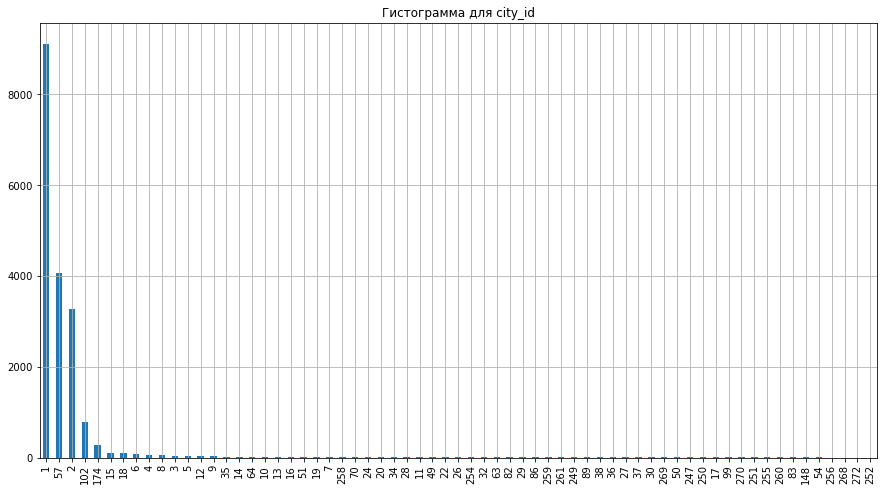

In [44]:
plt.figure(figsize=(15, 8))
df_clear['city_id'].value_counts().plot(kind='bar', grid=True)
plt.title("Гистограмма для city_id")

### Получение embeddings

##### Обработка полей custom_position и work_skills
Создадим словарь из текстов custom_position и work_skills

In [45]:
texts = pd.concat([df_clear['custom_position'], df_clear['work_skills']])
texts

0                                       [продавец, кассир]
1                                       [продавец, кассир]
2                                       [продавец, кассир]
3                                       [продавец, кассир]
4                                       [продавец, кассир]
                               ...                        
18538    [ответственность, продажи, работа, кассе, рабо...
18539    [фасовка, товара, выкладка, товара, стрессоуст...
18540    [спокойный, стиль, вождения, ответственность, ...
18541               [организация, общестроительных, работ]
18542    [уверенный, пользователь, пк, ремонт, оборудов...
Length: 37086, dtype: object

In [46]:
fasttext = gensim.models.FastText(
    vector_size=256,
    window=7,
    min_count=1
    )

In [47]:
fasttext.build_vocab(corpus_iterable=texts)
fasttext.train(
    corpus_iterable=texts,
    total_examples=len(texts),
    epochs=25
    )

(4962135, 6330700)

In [48]:
vectors = []

for item in df_clear['custom_position']:
    vectors.append(get_vector(fasttext, item))

cols = [f'feature_{i + 1}' for i in range(256)]
custom_position = pd.DataFrame(vectors, columns=cols)

df_clear = pd.concat([df_clear, custom_position], axis=1)

In [49]:
vectors = []

for item in df_clear['work_skills']:
    vectors.append(get_vector(fasttext, item))

cols = [f'feature_{i + 1}' for i in range(256, 256 + 256)]
work_skills = pd.DataFrame(vectors, columns=cols)

df_clear = pd.concat([df_clear, work_skills], axis=1)

In [50]:
df_clear.drop(['custom_position'], axis=1, inplace=True)
df_clear.drop(['work_skills'], axis=1, inplace=True)

In [53]:
df_clear

,schedule,salary_from,salary_to,offer_education_id,education_name,education_is_base,education_order_num,city_id,list_regions,tags_id,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,1,52000,58000,0,1,1,0,2,[4],"[6, 9]",...,1.046,-0.030,0.952,-0.595,0.051,-0.182,0.028,0.256,-0.185,-0.468
1,3,38000,38000,0,1,1,0,2,[4],[0],...,1.005,-0.070,0.194,-0.409,0.366,-0.008,-0.097,0.200,-0.135,-0.276
2,3,35000,40000,0,1,1,0,57,[207],[9],...,0.773,-0.176,0.650,-0.596,0.539,-0.609,0.080,0.519,-0.098,-0.330
3,3,37000,42000,0,1,1,0,57,[1269],[9],...,0.773,-0.176,0.650,-0.596,0.539,-0.609,0.080,0.519,-0.098,-0.330
4,1,33600,63000,0,1,1,0,57,[1220],[0],...,0.789,0.349,0.724,-0.530,0.771,-0.147,0.035,0.335,0.403,-0.295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18538,3,44000,60000,0,1,1,0,57,"[192, 1213, 5089]","[5, 6, 9]",...,0.630,-0.804,0.628,-0.544,0.506,-0.114,-0.187,0.159,0.070,-0.560
18539,1,110000,145000,0,1,1,0,57,"[181, 182, 183, 185, 186, 187, 188, 189, 190, ...",[0],...,1.382,-0.035,-0.068,-1.217,0.010,-0.643,0.252,0.649,0.194,0.095
18540,5,85000,120000,0,1,1,0,1,[3],"[5, 6, 9]",...,0.567,0.522,0.217,-0.581,-0.496,0.324,-1.178,-0.293,0.753,-0.131
18541,1,100000,100000,4,0,1,10,1,[3],[0],...,-1.945,-0.428,-0.033,-1.040,1.360,-0.840,0.440,0.704,0.475,0.230


In [52]:
# fasttext = gensim.models.FastText(
#     vector_size=100,
#     window=7,
#     min_count=1
#     )

# fasttext.build_vocab(corpus_iterable=df_clear['list_regions'])
# fasttext.train(
#     corpus_iterable=df_clear['list_regions'],
#     total_examples=len(df_clear['list_regions']),
#     epochs=25
#     )

KeyboardInterrupt: 

In [ ]:
# vectors = []

# for item in df_clear['list_regions']:
#     vectors.append(get_vector(fasttext, item))

# cols = [f'feature_{i + 1}' for i in range(256 * 2, 256 * 2 + 100)]
# list_regions = pd.DataFrame(vectors, columns=cols)

# df_clear = pd.concat([df_clear, list_regions], axis=1)